# Bankruptcy Classification

**Team Member:** **Yucheol-Shin**, **Ricco Ferraro**

# Business Understanding

Investment companies around the world spend incredible amounts of time and money building the investment portfolios. This challenge is no small feat, as a result companies are turning to data science to increase productivity and efficiency in making decisions on the potential investments. In this study, we will build a bankrupcy classification model that predicts if a company will go bankrupt or not. The primary classification tools that will be utilized are Random Forest and XGBoost. These two tools will provide the financial department the resources needed to make more educated choices when investing. The model is not intended to predict when the company will go bankruptcy, rather it is to predict whether or not it will go bankruptcy at all.

# Data Engineering

In [28]:
# imports 
import pandas as pd
from scipy.io import arff
pd.set_option('display.max_columns', 500)
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
%matplotlib inline
import seaborn as sns
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import glob, os
from matplotlib import figure
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_auc_score

In [29]:
#change directory folder
# Chris' path
os.chdir("C:/Users/Yuchie/Desktop/DataScience/SchoolProjects/Bankruptcy_Classification/data")

# Ricco's Path
# os.chdir('/Users/riccoferraro/Documents/SMU/QTW/QTW/casestudy4_data')

In [30]:
# Helper function to get feature names back from column transformer/scaler.
# From: https://johaupt.github.io/blog/columnTransformer_feature_names.html

def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)

    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
            # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            print("Transformer %s (type %s) does not "
                  "provide get_feature_names. "
                  "Will return input column names if available"
                  % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]

    ### Start of processing
    feature_names = []

    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))


    for name, trans, column, _ in l_transformers:
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))

    return feature_names

In [31]:
directories = ['1year.arff',
        '2year.arff',
        '3year.arff',
        '4year.arff',
        '5year.arff']
df = pd.DataFrame()
for directory in directories:
    mypath = Path.cwd()/directory
    data = arff.loadarff(mypath)
    dfTemp = pd.DataFrame(data[0])
    frames = [df,dfTemp]
    df = pd.concat(frames)
df.head()


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,0.249760,0.65980,0.166600,0.249760,497.42,0.73378,2.6349,0.249760,0.149420,43.370,1.2479,0.21402,0.119980,0.47706,0.50494,0.60411,1.45820,1.7615,5.9443,0.11788,0.149420,94.14,3.8772,0.56393,0.21402,1.7410,593.2700,0.50591,0.128040,0.662950,0.051402,0.128040,114.42,71.050,1.00970,1.52250,49.394,0.185300,0.110850,2.0420,0.37854,0.25792,2.2437,2.2480,348690.0,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,b'0'
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,0.261140,0.51680,0.158350,0.258340,677.96,0.53838,2.0005,0.258340,0.152000,87.981,1.4293,0.24806,0.123040,NaN,0.39542,0.43992,88.44400,16.9460,3.6884,0.26969,0.152000,122.17,2.9876,2.98760,0.20616,1.6996,NaN,0.49788,0.121300,0.086422,0.064371,0.145950,199.49,111.510,0.51045,1.12520,100.130,0.237270,0.139610,1.9447,0.49988,0.33472,17.8660,17.8660,2304.6,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,b'0'
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,0.312580,0.64184,0.244350,0.309060,794.16,0.45961,1.4369,0.309060,0.236100,73.133,1.4283,0.30260,0.189960,NaN,0.28932,0.37282,86.01100,1.0627,4.3749,0.41929,0.238150,176.93,2.0630,1.42740,0.31565,1.3090,2.3019,0.51537,0.241140,0.322020,0.074020,0.231170,165.51,92.381,0.94807,1.01010,96.372,0.291810,0.222930,1.0758,0.48152,0.48474,1.2098,2.0504,6332.7,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,b'0'
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,0.092704,0.30163,0.094257,0.092704,917.01,0.39803,3.2537,0.092704,0.071428,79.788,1.5069,0.11550,0.062782,0.17193,0.57353,0.36152,0.94076,1.9618,4.6511,0.14343,0.071428,91.37,3.9948,0.37581,0.11550,1.3562,NaN,0.57353,0.088995,0.401390,0.069622,0.088995,180.77,100.980,0.28720,1.56960,84.344,0.085874,0.066165,2.4928,0.30734,0.25033,2.4524,2.4524,20545.0,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,b'0'
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,0.187320,0.33147,0.121820,0.187320,1133.20,0.32211,1.6307,0.187320,0.115530,57.045,NaN,0.19832,0.115530,0.18732,0.38677,0.32211,1.41380,1.1184,4.1424,0.27884,0.115530,147.04,2.4823,0.32340,0.19832,1.6278,11.2470,0.43489,0.122310,0.293040,0.096680,0.122310,141.62,84.574,0.73919,0.95787,65.936,0.188110,0.116010,1.2959,0.56511,0.40285,1.8839,2.1184,3186.6,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,b'0'


In [32]:
df.describe(include = "all")

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,43397.000000,43397.000000,43397.000000,43271.000000,4.331600e+04,43397.000000,43397.000000,43311.000000,43396.000000,43397.000000,43361.000000,43271.000000,43278.000000,43397.000000,4.336900e+04,43310.000000,43311.000000,43397.000000,43277.000000,4.327800e+04,37551.000000,43397.000000,43278.000000,42483.000000,43397.000000,43310.000000,4.064100e+04,42593.000000,43397.000000,43278.000000,43278.000000,4.303700e+04,43271.000000,43311.000000,43397.000000,43397.000000,24421.000000,43397.000000,43278.000000,43271.000000,42651.000000,43278.000000,4.327800e+04,4.327800e+04,41258.000000,43270.000000,4.310800e+04,43396.000000,43278.000000,43311.000000,43397.000000,43104.000000,42593.000000,42593.000000,4.340400e+04,4.327800e+04,43398.000000,4.332100e+04,43398.000000,4.125300e+04,43303.000000,4.327800e+04,43271.000000,42593.000000,43405
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b'0'
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41314
mean,0.035160,0.590212,0.114431,6.314702,-3.853466e+02,-0.056107,0.093478,12.640779,2.652166,0.626868,0.131075,1.132430,0.809544,0.093489,1.991890e+03,1.411167,13.802535,0.098565,0.156277,2.430209e+02,3.884997,0.113923,0.138582,0.270012,0.392844,1.263864,1.107896e+03,6.003208,4.005020,7.370821,0.176847,1.162621e+03,8.636016,5.411439,0.111908,2.911241,105.085363,0.724357,-0.289102,2.147411,7.717806,-0.142514,1.074125e+03,8.311085e+02,14.825016,5.428857,3.578418e+02,0.028584,-0.482584,5.835373,0.483521,6.478459,23.772623,24.654700,7.672188e+03,-2.621959e+01,-0.010510,3.002644e+01,1.333288,4.480858e+02,17.033202,1.502328e+03,9.343074,72.788592,NaN
std,2.994109,5.842748,5.439429,295.434425,6.124303e+04,7.201326,5.713075,505.894281,62.932732,14.670597,5.306782,67.590296,86.944053,5.713075,9.643193e+04,68.519998,507.322101,5.737645,48.692154,3.754517e+04,228.668931,5.155778,48.334974,7.988151,12.891440,66.224124,3.501237e+04,153.468628,0.826857,814.490078,48.748410,9.559356e+04,118.991185,120.975110,4.783398,62.984347,3058.429830,14.749270,39.256360,56.029879,1398.837543,15.990988,1.472188e+05,1.100510e+05,2428.236110,295.356200,3.314634e+04,5.097322,45.152174,307.382687,5.438357,639.887467,1213.797976,1220.884065,7.005310e+04,5.327862e+03,13.674072,5.334454e+03,122.104445,3.234560e+04,553.049406,1.392667e+05,124.177354,2369.339482,NaN
min,-463.890000,-430.870000,-479.960000,-0.403110,-1.190300e+07,-508.410000,-517.480000,-141.410000,-3.496000,-479.910000,-463.890000,-6331.800000,-1460.600000,-517.480000,-9.632400e+06,-6331.800000,-0.412920,-517.480000,-1578.700000,-2.934000e+01,-1325.000000,-431.590000,-1578.700000,-463.890000,-500.930000,-6331.800000,-2.590100e+05,-3829.900000,-0.886060,-6351.700000,-1495.600000,-9.295600e+03,-19.197000,-1696.000000,-431.590000,-0.000857,-525.520000,-479.910000,-7522.000000,-101.270000,-1234.400000,-1395.800000,-1.158700e+05,-1.158700e+05,-256230.0000

Below you can see that our bankrupcy label `class` is highly imbalanced in our dataset, with the majority of the data being labled `b'0'` representing NOT bankrupt. 

Text(0.5, 1.0, 'Class value count')

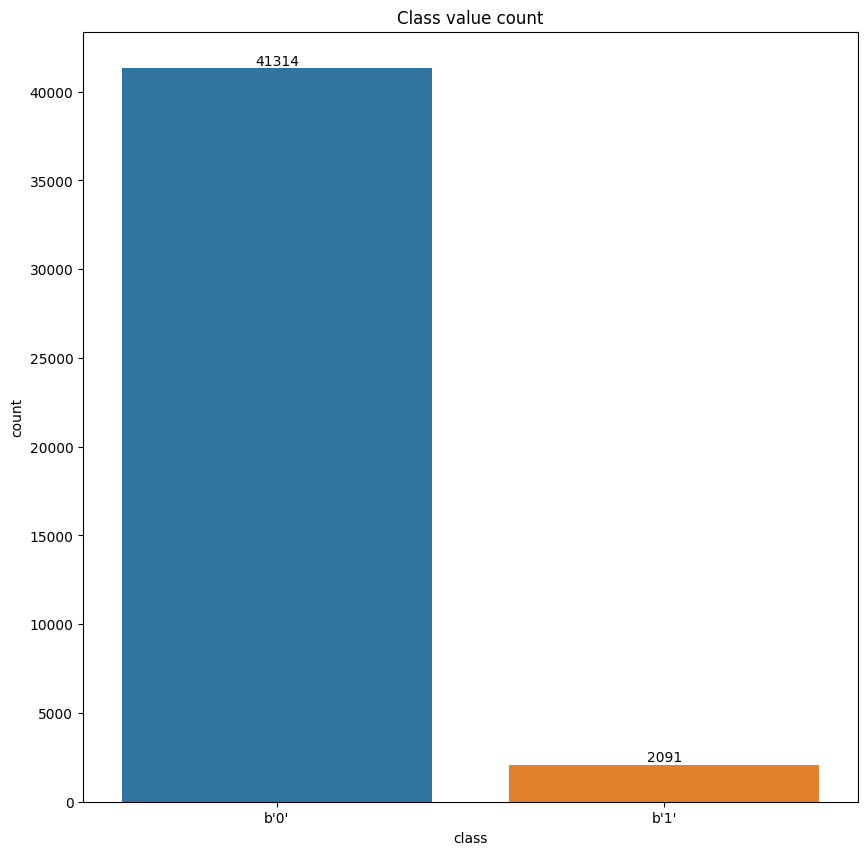

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10));
sns.countplot(data = df, x="class");
abs_values = df['class'].value_counts(ascending=False).values;
ax.bar_label(container=ax.containers[0], labels=abs_values);
ax.set_title("Class value count")

### Missing Data:
As can be seen, a majority of the variables have missing values. The range of the amount of missing values vary across the variables. While most of the variables in the dataset have less then *10%* missing values, `Attr21` has close to *15%* and `Attr37` has a more extreme amount at almost *50%*. Even though these figures are cause for concern, our imputation method and **Random Forest** and **XGBoost** models should be able to cope with `Attr37` and `Attr21`.

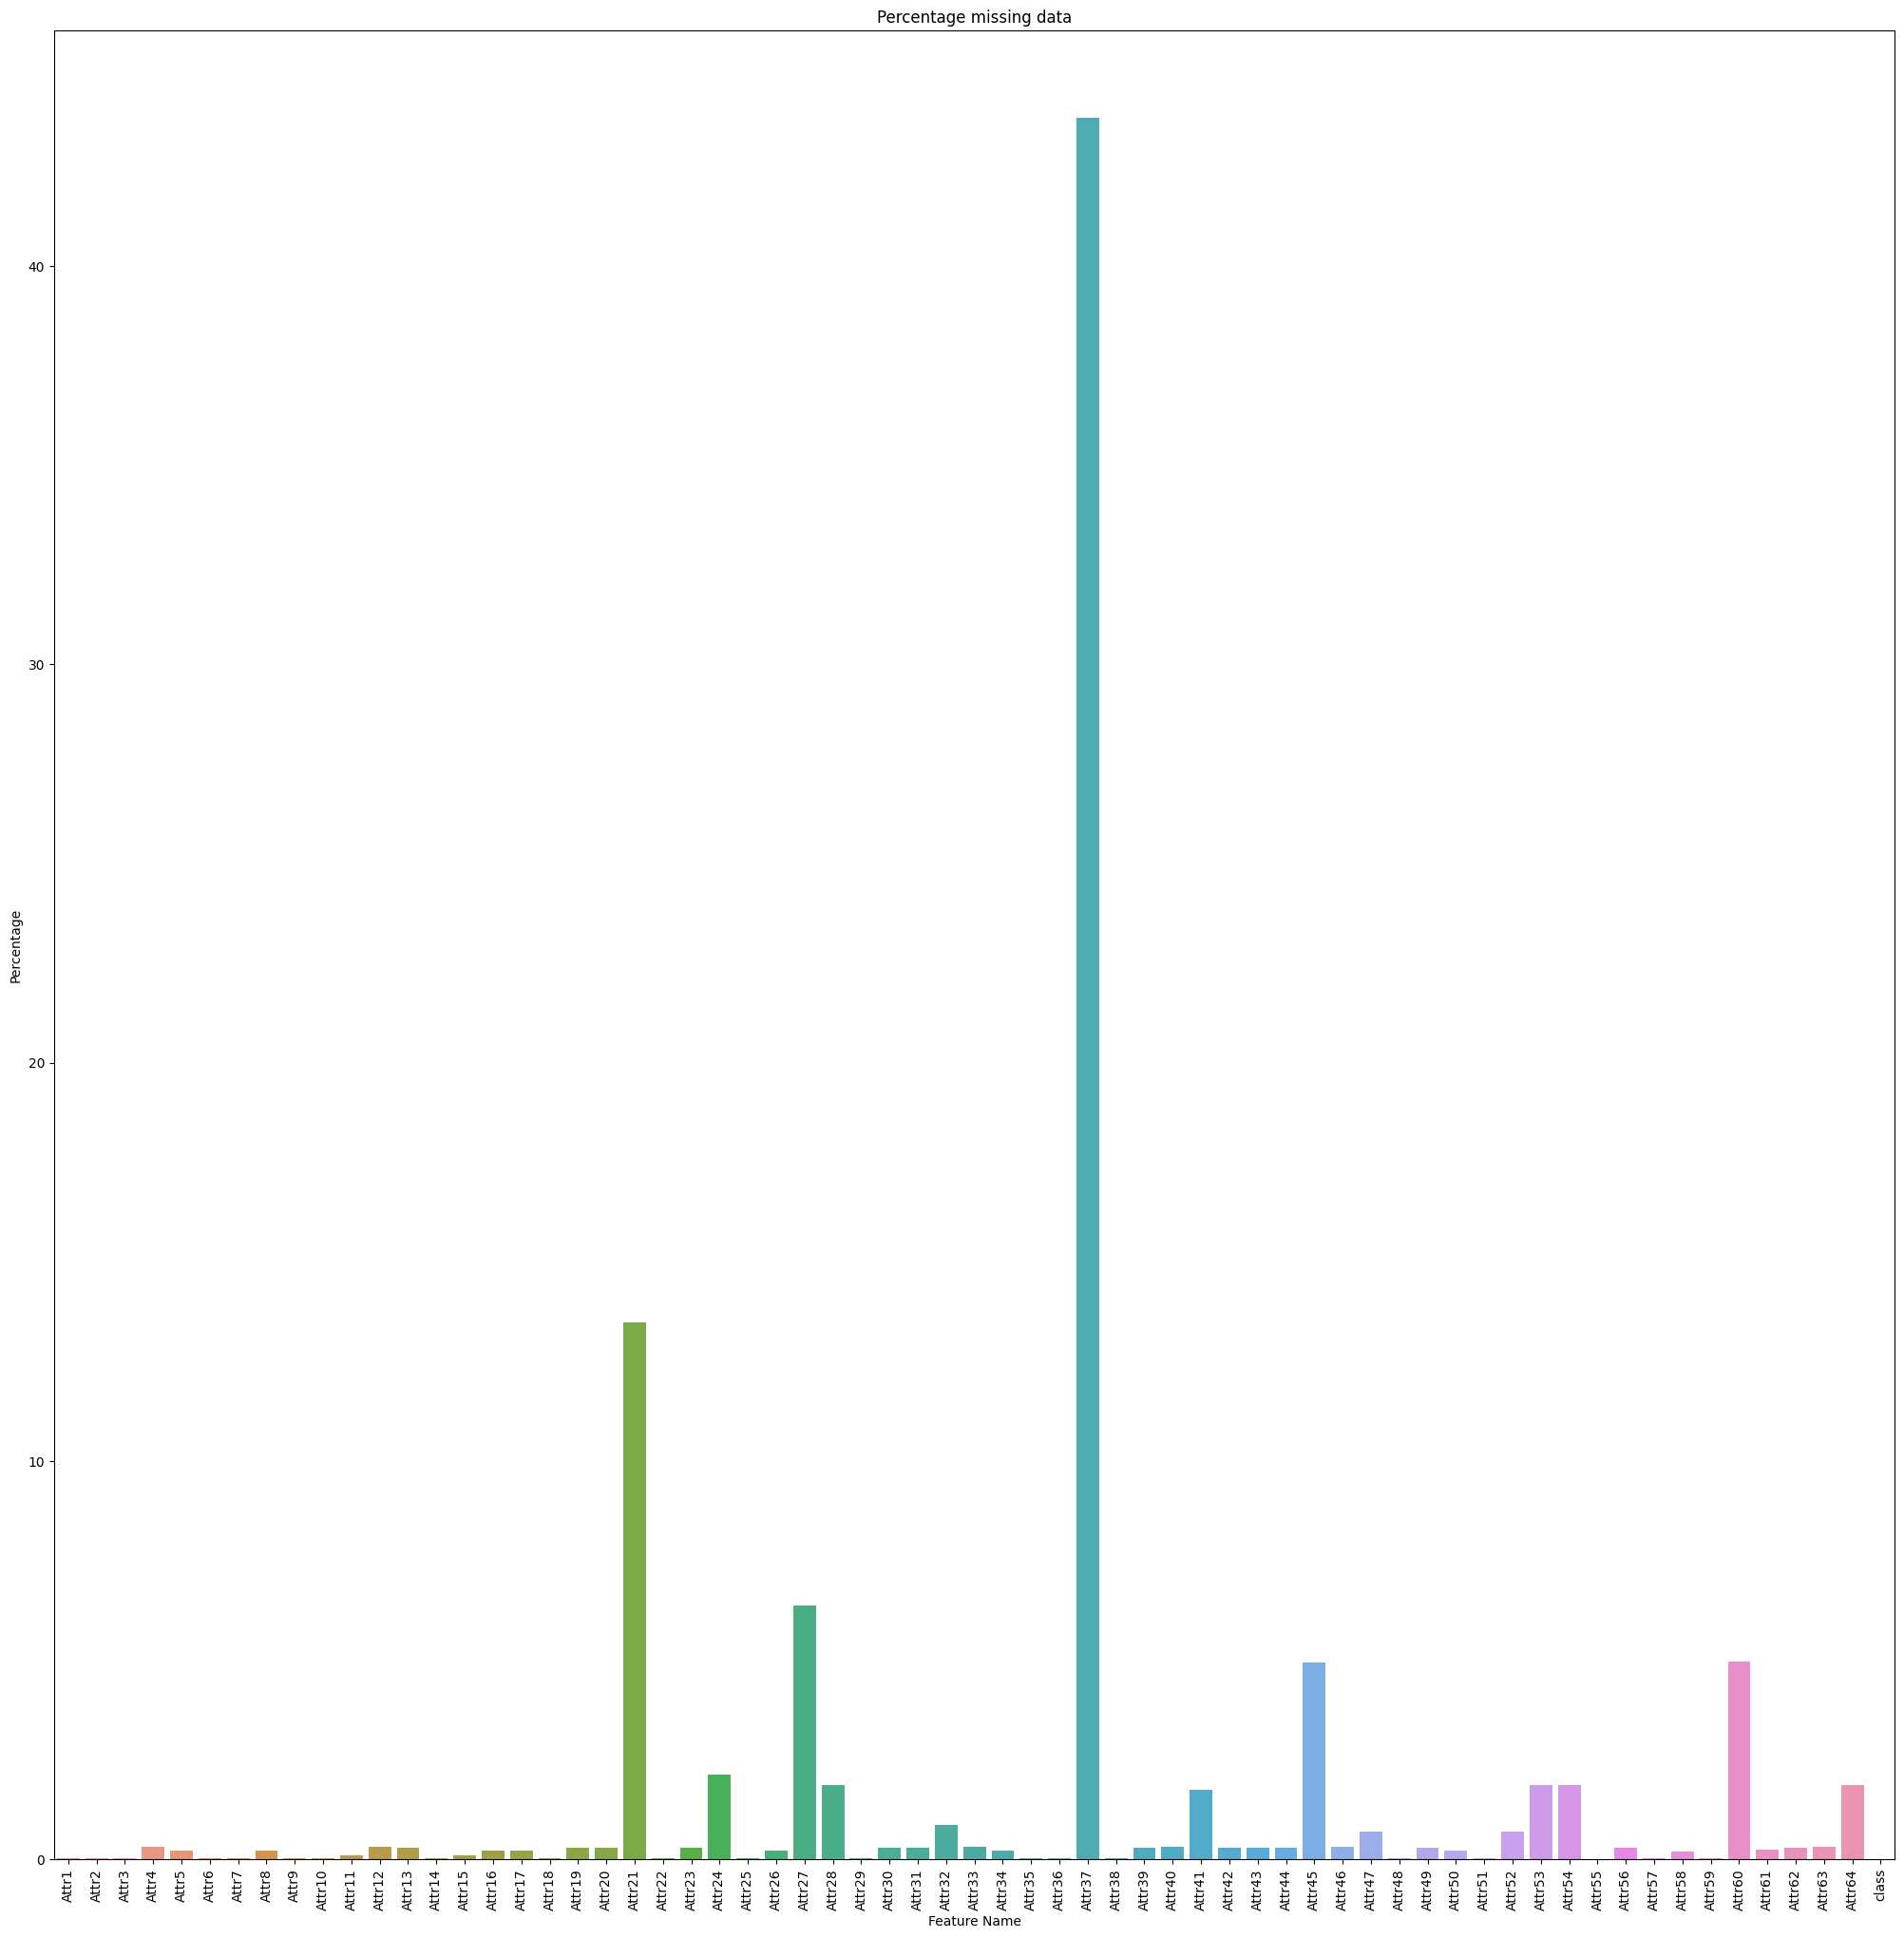

In [34]:
num_vars =df.columns[df.dtypes != 'object'];
percent_missing = df.isnull().sum() * 100 / len(df);
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing});

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,25));
sns.barplot(data = missing_value_df, x='column_name', y='percent_missing', ax = ax);
ax.set_title("Percentage missing data");
ax.set_ylabel("Percentage");
ax.set_xlabel("Feature Name");
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

## Model Preparation
### Proposed Methods
We use Random Forest and XGBoost to classify if a company will under go bankrupcy under given conditions. One benefit to using XGBoost and Random Forest is that they are known for handling skewness of explanatory variables and don't require log transforming the input features. Further, these CART or boosting classification algorithms handle outliers farily effectively and so outlier removal shouldn't be needed. XGBoost is even known for handling missing values gracefully. Random Forest and XGBoost are also preferred due to their interpretable variable importances.

### Target Variable
Target is ``'class'``, 1 is bankrupcy, 0 is no bankrupcy.


### Scaling
In order to compare feature importances and to ensure the best predictive power, standardized z-score centering and scaling is performed on all explanatory features. 

### Feature Selection
In order to mitigate model overfitting and also feature importance which would otherwise be dominated by highly multicolinear variables, after imputation and scaling, no missing data is left and all variables are included in our models.

### Test/Train split
In order to evaluate the quality of this binary classification problem, we choose a randomized ``80%/20%`` train/test split where 80% of the data is used for training and 5 fold cross validation, and the remaining 20% data is held out to evaluate test accuracy, test precision, test recall. By keeping a holdout set, and being careful not to allow any of that holdout 'test' set to leak into our model, including feature engineering, we can be more confident in the test metrics such as Precision, Recall, or Test ROC AUC.

### Evaluation Method
Because our case study is a binary classification problem, bankrupcy or no bankrupcy, we can visualize the outcome of a binary classification model using a confusion matrix to generate metrics like precision, recall (where test precision is considered more important than recall).

Because we know that our dataset is unbalanced in terms of `'class'`, where there are roughly ---- more no bankrupcy observations, we choose ROC Area under the curve as a scoring technique to train the random forest and XGBoost model. This technique better facilitates thresholding (picking the optimum cutoff probabilities to classify 'bankrupcy' or 'no bankrupcy') so that an optimal value of precision and recall can be chosen.
One tradeoff, by choosing to optimize for ROC AUC, is that predicive accuracy may decrease slightly.

After we evaulte the model with the ROC AUC score, we thresholds our predictions to adjust the recall vs precisoin. Predicting the Non bankruptcy as actual bankruptcy is more critical. To reduce this consequence, it requires higher recall and thresholding is applied.

For more information on ROC curves, accuracy, precision, recall, etc, please see [here](https://www.baeldung.com/cs/classification-model-evaluation)

# Preprocessing

In [35]:
df_test_train_split_copy = df.copy()
df_test_train_split_copy = df_test_train_split_copy.replace([b'1', b'0'], [1,0])
train, test = train_test_split(df_test_train_split_copy, test_size=0.2)
X_train = train.drop(columns=['class'])
y_train = train['class']
X_test = test.drop(columns=['class'])
y_test = test['class']
y_train = y_train.replace([b'1', b'0'], [1,0])
y_test = y_test.replace([b'1', b'0'], [1,0])

In [36]:
y_train.describe()

count    34724.000000
mean         0.048698
std          0.215240
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: class, dtype: float64

### Imputing Missing values
Because we have little domain knowledge with regards to the nature of each feature, we prefer imputing missing data in a 'domain agnostic' manner. Below you can see that we have used sorted cross correlation for each attribute to build imputation models for each attribute based on its top 5 highly correlated "sibling" features. This is accomplished by taking the highest correlated siblings, and attempting to impute missing values from them for each given feature. In the case where the most correlated sibling feature is also missing, we default to the next most correlated feature and so on. If all of the top 5 most cross correlated features are also missing, lastly, the median value is used for each feature to impute.


Below you can see a cross correlation heatmap between various explanatory features or attributes. We can see that there does exist a strong correlation between many of the attributes. For example, Attribute 43 and 44 are strongly negatively correlated. This will be useful later, when we impute missing values.

Note: Attributes `21` and `37` have almost no cross correlation or "multicolinearity" with other variables. The imputation algorithm we use below specifically performs more powerfully in its prediction when there is correlation between a given explanatory variable and the other variables. For this resaon, we don't expect a great imputation prediction for attribute21 adn 37. 

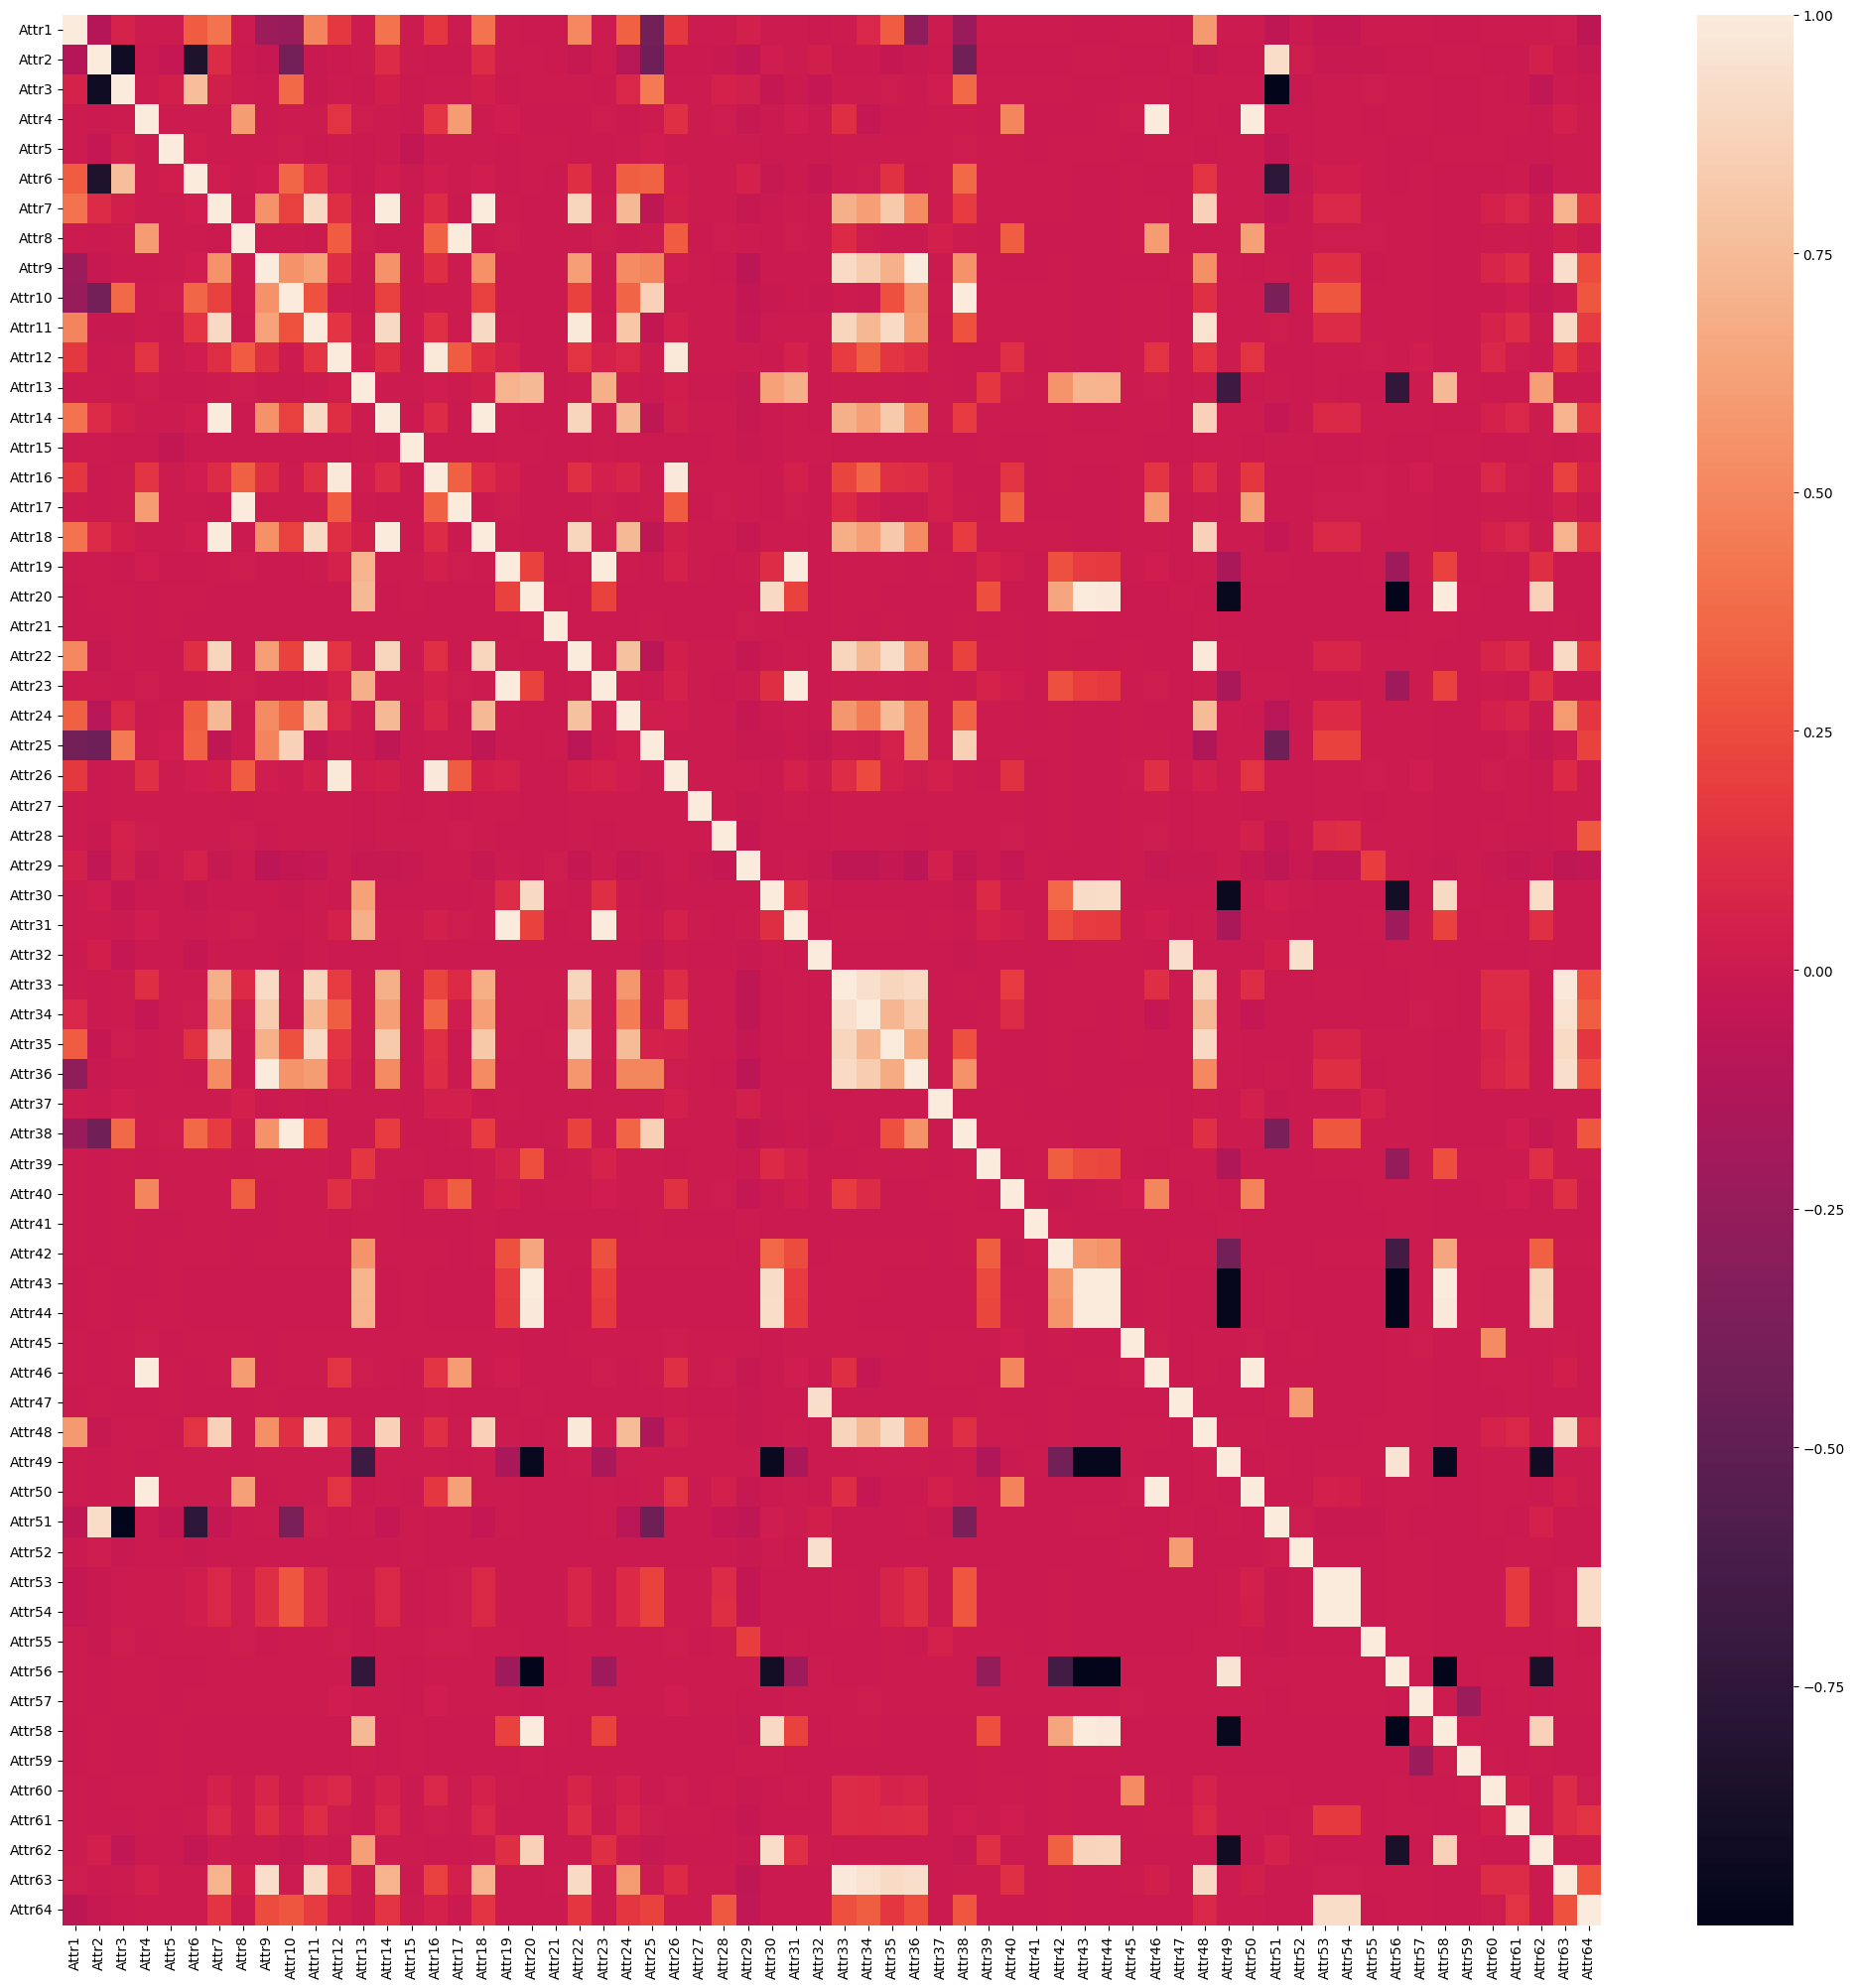

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,25));
sns.heatmap(df.drop(columns=['class']).corr(), ax = ax);

In [38]:
cross_correlation_train = X_train.corr()
cross_correlation_train

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
Attr1,1.000000,-0.125419,0.070498,0.000876,0.009325,0.380181,0.374999,-0.000335,-0.118893,-0.130981,0.465954,0.249642,0.001958,0.374999,0.000140,0.241084,-0.000094,0.373836,0.003607,-0.000060,-0.001842,0.465304,0.003748,0.316283,-0.276684,0.251202,0.007185,0.002506,0.030628,-0.000131,0.003593,-0.003653,0.004511,0.098941,0.340232,-0.181907,0.001338,-0.123384,0.000979,0.002811,0.000179,0.002853,-0.000105,-0.000121,0.000983,0.000668,-0.000947,0.557336,0.001111,0.000916,-0.068846,-0.001617,-0.027327,-0.027195,0.003724,0.000058,0.006979,-0.000345,-0.000520,0.000175,0.007229,-0.000101,0.007433,-0.063778
Attr2,-0.125419,1.000000,-0.915413,-0.001383,-0.121271,-0.826736,0.112999,-0.002281,-0.020665,-0.408323,-0.009805,-0.000227,0.000201,0.112999,0.001344,-0.001424,-0.002303,0.112654,0.000057,0.000206,0.000205,-0.019679,-0.000259,-0.096459,-0.466518,-0.001324,-0.002406,-0.007868,-0.049276,0.021774,0.000246,0.031783,-0.002638,-0.001936,-0.024638,-0.020315,-0.002351,-0.422252,-0.002057,-0.002475,-0.000464,-0.002026,0.000575,0.000698,-0.002075,-0.001186,0.001028,-0.016052,-0.001009,-0.001410,0.914720,0.011580,-0.011837,-0.011610,-0.009041,-0.000257,-0.000885,0.000296,0.000822,-0.000035,-0.003568,0.045830,-0.002941,-0.016542
Attr3,0.070498,-0.915413,1.000000,0.002050,0.131916,0.731932,0.037313,0.001370,-0.001088,0.362877,-0.011688,0.001481,-0.000237,0.037313,-0.001209,0.001696,0.001376,0.037185,-0.000303,0.000015,-0.000276,-0.001046,-0.000345,0.080600,0.477636,0.001623,0.002584,0.062622,0.045128,-0.023318,-0.000510,-0.034587,0.003469,0.002430,0.001702,-0.001042,0.015908,0.360316,0.002215,0.004046,0.000564,0.002606,-0.000331,-0.000448,0.002672,0.001868,-0.001178,-0.001132,0.000931,0.002039,-0.998448,-0.013138,-0.000071,0.000186,0.010558,0.000018,0.000869,-0.000037,-0.000597,0.000307,-0.002032,-0.049636,0.003592,-0.001856
Attr4,0.000876,-0.001383,0.002050,1.000000,0.003933,-0.000015,0.000156,0.693508,-0.000407,0.001457,0.000090,0.155382,0.017506,0.000156,-0.000270,0.154387,0.693431,0.000138,0.031793,-0.000466,-0.001191,-0.000095,0.027101,0.000006,0.001062,0.131415,0.000129,0.016896,-0.017024,-0.002390,0.031919,-0.000175,0.082947,-0.064576,-0.000129,-0.000454,0.005639,0.001251,-0.002836,0.458250,-0.000089,-0.013004,-0.000204,-0.000113,0.001157,0.999935,-0.000170,0.000107,-0.004095,0.998581,-0.001356,-0.000196,0.003474,0.003723,0.000054,0.000485,0.000136,-0.000512,-0.000536,-0.000684,-0.000366,-0.001199,0.006217,-0.000726
Attr5,0.009325,-0.121271,0.131916,0.003933,1.000000,0.096673,0.004538,0.004207,0.001435,0.048607,-0.002227,0.000978,-0.001771,0.004538,-0.123974,0.001220,0.004212,0.004527,-0.003150,0.000054,0.000065,-0.000393,-0.002574,0.010176,0.063724,0.001167,0.000601,0.001408,0.010552,-0.003826,-0.003226,-0.010549,0.001088,0.000303,0.000136,0.000500,-0.000087,0.048356,0.000387,0.004493,-0.000694,0.002238,0.002353,0.003129,-0.000489,0.003894,0.000363,-0.000472,0.000760,0.004747,-0.132005,-0.004072,0.000143,0.000151,0.002997,-0.000046,0.000050,0.000033,0.000280,0.000060,0.000393,-0.008033,0.000907,0.000421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Attr60,0.000175,-0.000035,0.000307,-0.000684,0.000060,-0.000070,0.055322,-0.000169,0.081073,-0.000226,0.062650,0.086964,-0.000106,0.055322,-0.000215,0.088074,-0.000170,0.055143,0.000008,-0.000098,-0.000161,0.064835,0.000004,0.046716,-0.000135,0.015026,

In [39]:
def get_train_imputation_models(column_name_to_impute, top5_most_correlated_features):
    top5_most_correlated_features = top5_most_correlated_features.drop(column_name_to_impute)
    X_train_no_na = X_train.dropna()
    random_5000_sample_X_train = X_train_no_na.sample(5000)
    trained_models = {}
    for rank, top_correlated_feature_name in enumerate(top5_most_correlated_features):
        X_impute = random_5000_sample_X_train[[top_correlated_feature_name]];
        y_impute = random_5000_sample_X_train[column_name_to_impute];
        trained_model = LinearRegression().fit(X_impute, y_impute);
        trained_models[rank] = top_correlated_feature_name, trained_model
    return trained_models

def get_imputation_model_dictionary():
    imputation_model_dictionary = {}
    for column_name in X_train.columns:
        top3_most_correlated_features = abs(cross_correlation_train[column_name]).sort_values(ascending=False).head(6)
        imputation_model_dictionary[column_name] = get_train_imputation_models(column_name, top3_most_correlated_features.index)
    return imputation_model_dictionary

imputation_model_dictionary = get_imputation_model_dictionary()

In [40]:
def impute_row(all_attribute_imputation_model_dictionary, row):
    X_train_no_na = X_train.dropna()
    for column_name in list(row.index):
        if pd.isnull(row[column_name]):
            for rank in range(5): 
                single_attribute_imputation_model_by_rank_dictionary = all_attribute_imputation_model_dictionary[column_name]
                feature_name_to_impute_with, imputation_model = single_attribute_imputation_model_by_rank_dictionary[rank]
                if not pd.isnull(row[feature_name_to_impute_with]):
                    value_to_impute_with = np.array([row[feature_name_to_impute_with]]).reshape(1, -1)
                    prediction = imputation_model.predict(value_to_impute_with)
                    row[column_name] = prediction
                    break

        # if the value is still null, that means no model was available to predict. thus use median.
        if pd.isnull(row[column_name]):
            row[column_name] = np.median(X_train_no_na[column_name])

X_train_imputed = X_train.copy()
X_test_imputed = X_test.copy()
X_train_imputed.apply(lambda x: impute_row(imputation_model_dictionary, x) if x.isna().any() else x, axis=1);
X_test_imputed.apply(lambda x: impute_row(imputation_model_dictionary, x) if x.isna().any() else x, axis=1);

In [41]:
print(f'Original data had missing values: {X_train.copy().isna().sum()}')
print(f'Imputed data had missing values: {X_train_imputed.isna().sum()}')

Original data had missing values: Attr1        5
Attr2        5
Attr3        5
Attr4      109
Attr5       69
          ... 
Attr60    1695
Attr61      86
Attr62     107
Attr63     109
Attr64     653
Length: 64, dtype: int64
Imputed data had missing values: Attr1     0
Attr2     0
Attr3     0
Attr4     0
Attr5     0
         ..
Attr60    0
Attr61    0
Attr62    0
Attr63    0
Attr64    0
Length: 64, dtype: int64


#### Pre-imputation vs Imputation Analysis
As can be seen below, the pre-imputation and post-imputation plots highlight whether or not underlying distributions have been affected by our regression based imputation model above. Specifically, for attribute 37 and also attribute 21, the lack of correlation to other explantory variables, (mentioned above and visually evident in our cross correlation heatmap) means that the imputed data is not as accurate as it could be given other more predictive multicolinear variables.  As such, it is not surprising that the distribution for Attribute 37 changes slightly, especially given that almost ~50% of the values needed to be imputed (see % missing plot above). The same is true for attribute 21 where ~14% of the data is also missing and thus many imputed values were needed. 

One thing you can see is that there are indeed outliers and these variables do contain skewness. As metentioned earlier, outliers and skewness are handled by the models we choose to use in this study, as such, we shouldn't need to worry about them too much. 

Text(0.5, 1.0, 'Post Imputation')

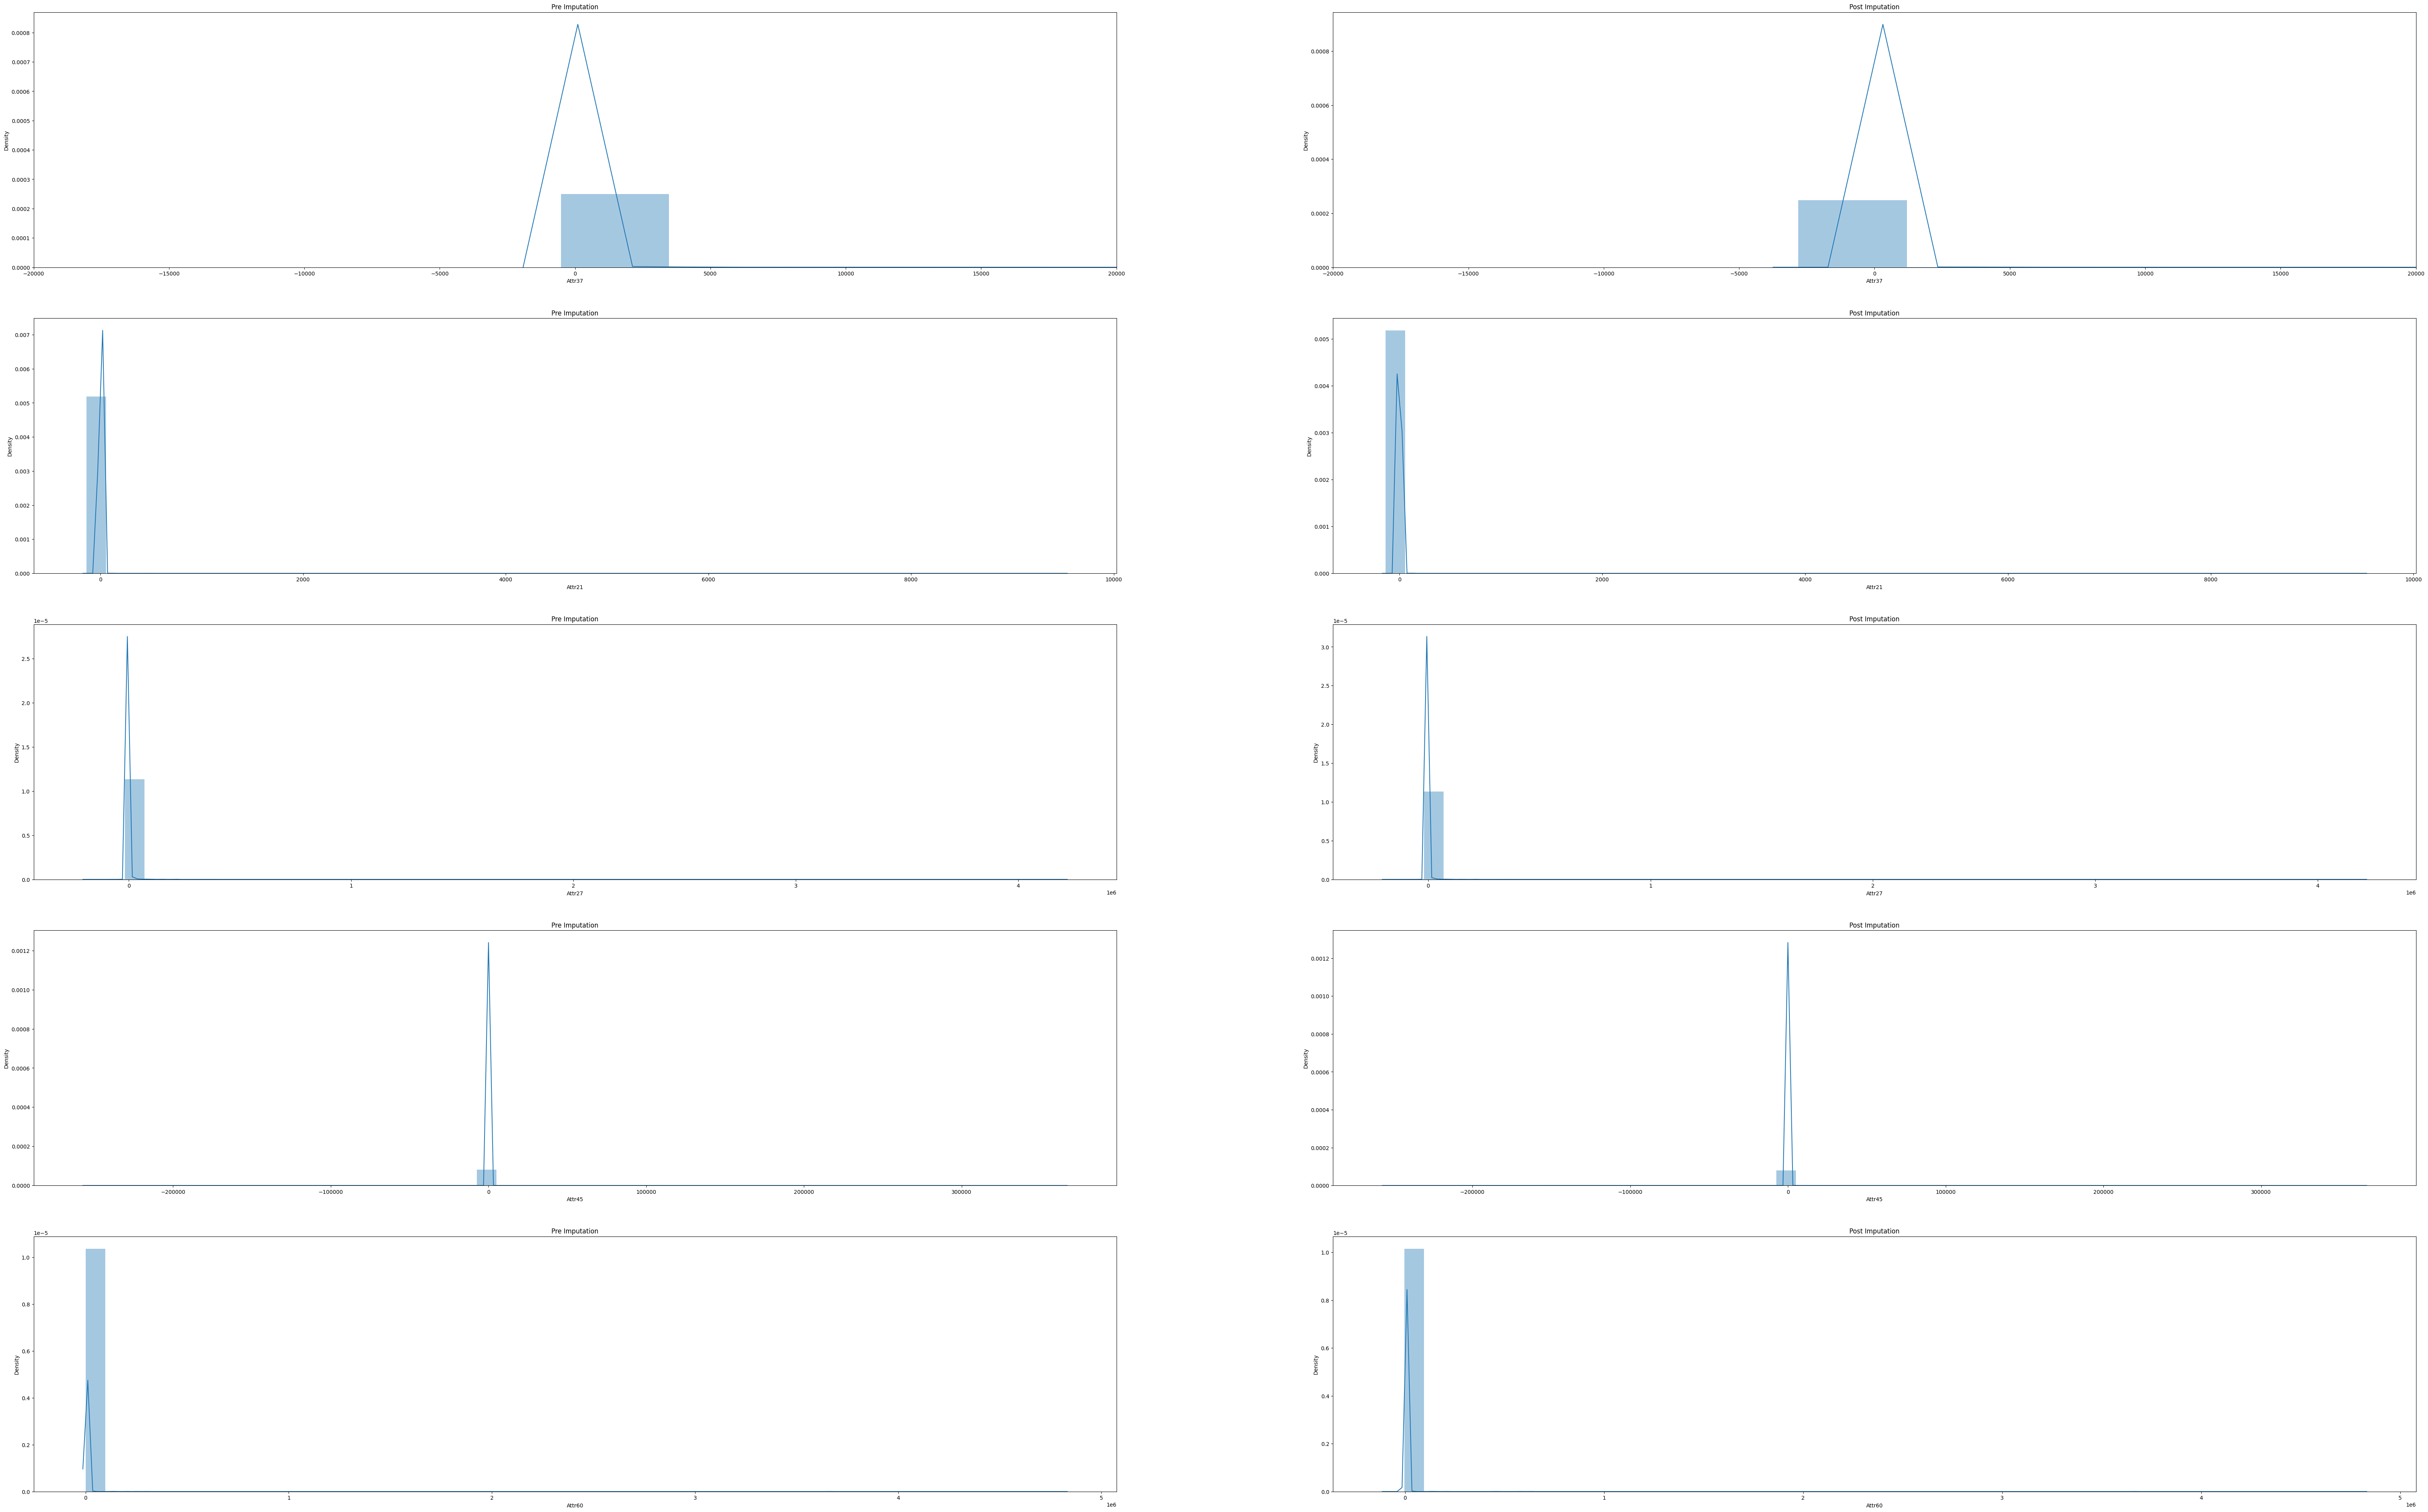

In [42]:
X_and_y_pre_imputation = X_train.copy()
X_and_y_post_imputation = X_train_imputed.copy()
X_and_y_pre_imputation['class'] = y_train
X_and_y_post_imputation['class'] = y_train
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(80,50))

ax = axs[0,0]
sns.distplot(X_and_y_pre_imputation['Attr37'], ax = ax, bins=100)
ax.set_title("Pre Imputation")
ax.set_xlim(-20000, 20000)

ax = axs[0,1]
sns.distplot(X_and_y_post_imputation['Attr37'], ax = ax, bins=100)
ax.set_title("Post Imputation")
ax.set_xlim(-20000, 20000)

ax = axs[1,0]
sns.distplot(X_and_y_pre_imputation['Attr21'], ax = ax)
ax.set_title("Pre Imputation")

ax = axs[1,1]
sns.distplot(X_and_y_post_imputation['Attr21'], ax = ax)
ax.set_title("Post Imputation")


ax = axs[2,0]
sns.distplot(X_and_y_pre_imputation['Attr27'], ax = ax)
ax.set_title("Pre Imputation")
ax = axs[2,1]
sns.distplot(X_and_y_post_imputation['Attr27'], ax = ax)
ax.set_title("Post Imputation")


ax = axs[3,0]
sns.distplot(X_and_y_pre_imputation['Attr45'], ax = ax)
ax.set_title("Pre Imputation")
ax = axs[3,1]
sns.distplot(X_and_y_post_imputation['Attr45'], ax = ax)
ax.set_title("Post Imputation")


ax = axs[4,0]
sns.distplot(X_and_y_pre_imputation['Attr60'], ax = ax)
ax.set_title("Pre Imputation")
ax = axs[4,1]
sns.distplot(X_and_y_post_imputation['Attr60'], ax = ax)
ax.set_title("Post Imputation")

In [43]:
# # pickle test and train.
X_and_y_train  = X_train_imputed.copy()
X_and_y_test  = X_test_imputed.copy()
X_and_y_train['class'] = y_train
X_and_y_test['class'] = y_test
joblib.dump(X_and_y_train.sort_index(), "X_and_y_train_casestudy_04.pkl")
joblib.dump(X_and_y_test.sort_index(), "X_and_y_test_casestudy_04.pkl")

['X_and_y_test_casestudy_04.pkl']

In [44]:
 # Run from here as needed
X_and_y_train = joblib.load("X_and_y_train_casestudy_04.pkl").sort_index()
X_and_y_test = joblib.load("X_and_y_test_casestudy_04.pkl").sort_index()
X_train_imputed = X_and_y_train.drop(columns=['class'])
X_test_imputed = X_and_y_test.drop(columns=['class'])
y_train = X_and_y_train['class']
y_test = X_and_y_test['class']

In [45]:
# Scale the data
# fit our scaler based only based on training data to avoid data leakage
t_slr = [('scale', StandardScaler(), X_train_imputed.columns)]
col_transform = ColumnTransformer(t_slr, remainder='passthrough')
col_transform.fit(X_train_imputed)
X_train_imputed_and_scaled_array = col_transform.transform(X_train_imputed)
X_test_imputed_and_scaled_array = col_transform.transform(X_test_imputed)
column_names = get_feature_names(col_transform)
X_train_scaled = pd.DataFrame(data=X_train_imputed_and_scaled_array, columns=column_names)
X_test_scaled = pd.DataFrame(data=X_test_imputed_and_scaled_array, columns=column_names)

Transformer scale (type StandardScaler) does not provide get_feature_names. Will return input column names if available


#### PCA
Due to the large number of explanatory variables and our lack of domain expertise, we choose to perform a principal component analysis and visually inspect distribution difference along our principal components between class=0 and class=1. As can be seen, there is some but not strong sperabilitiy along Principal component 3 and principal component 4. If we inspect the eigen vector loadings for these principal components we can get a sense of which attributes contribute to the seperation of class 0 and 1. Again, outliers and the skewed nature of our data can be visually detected along our principal components. 

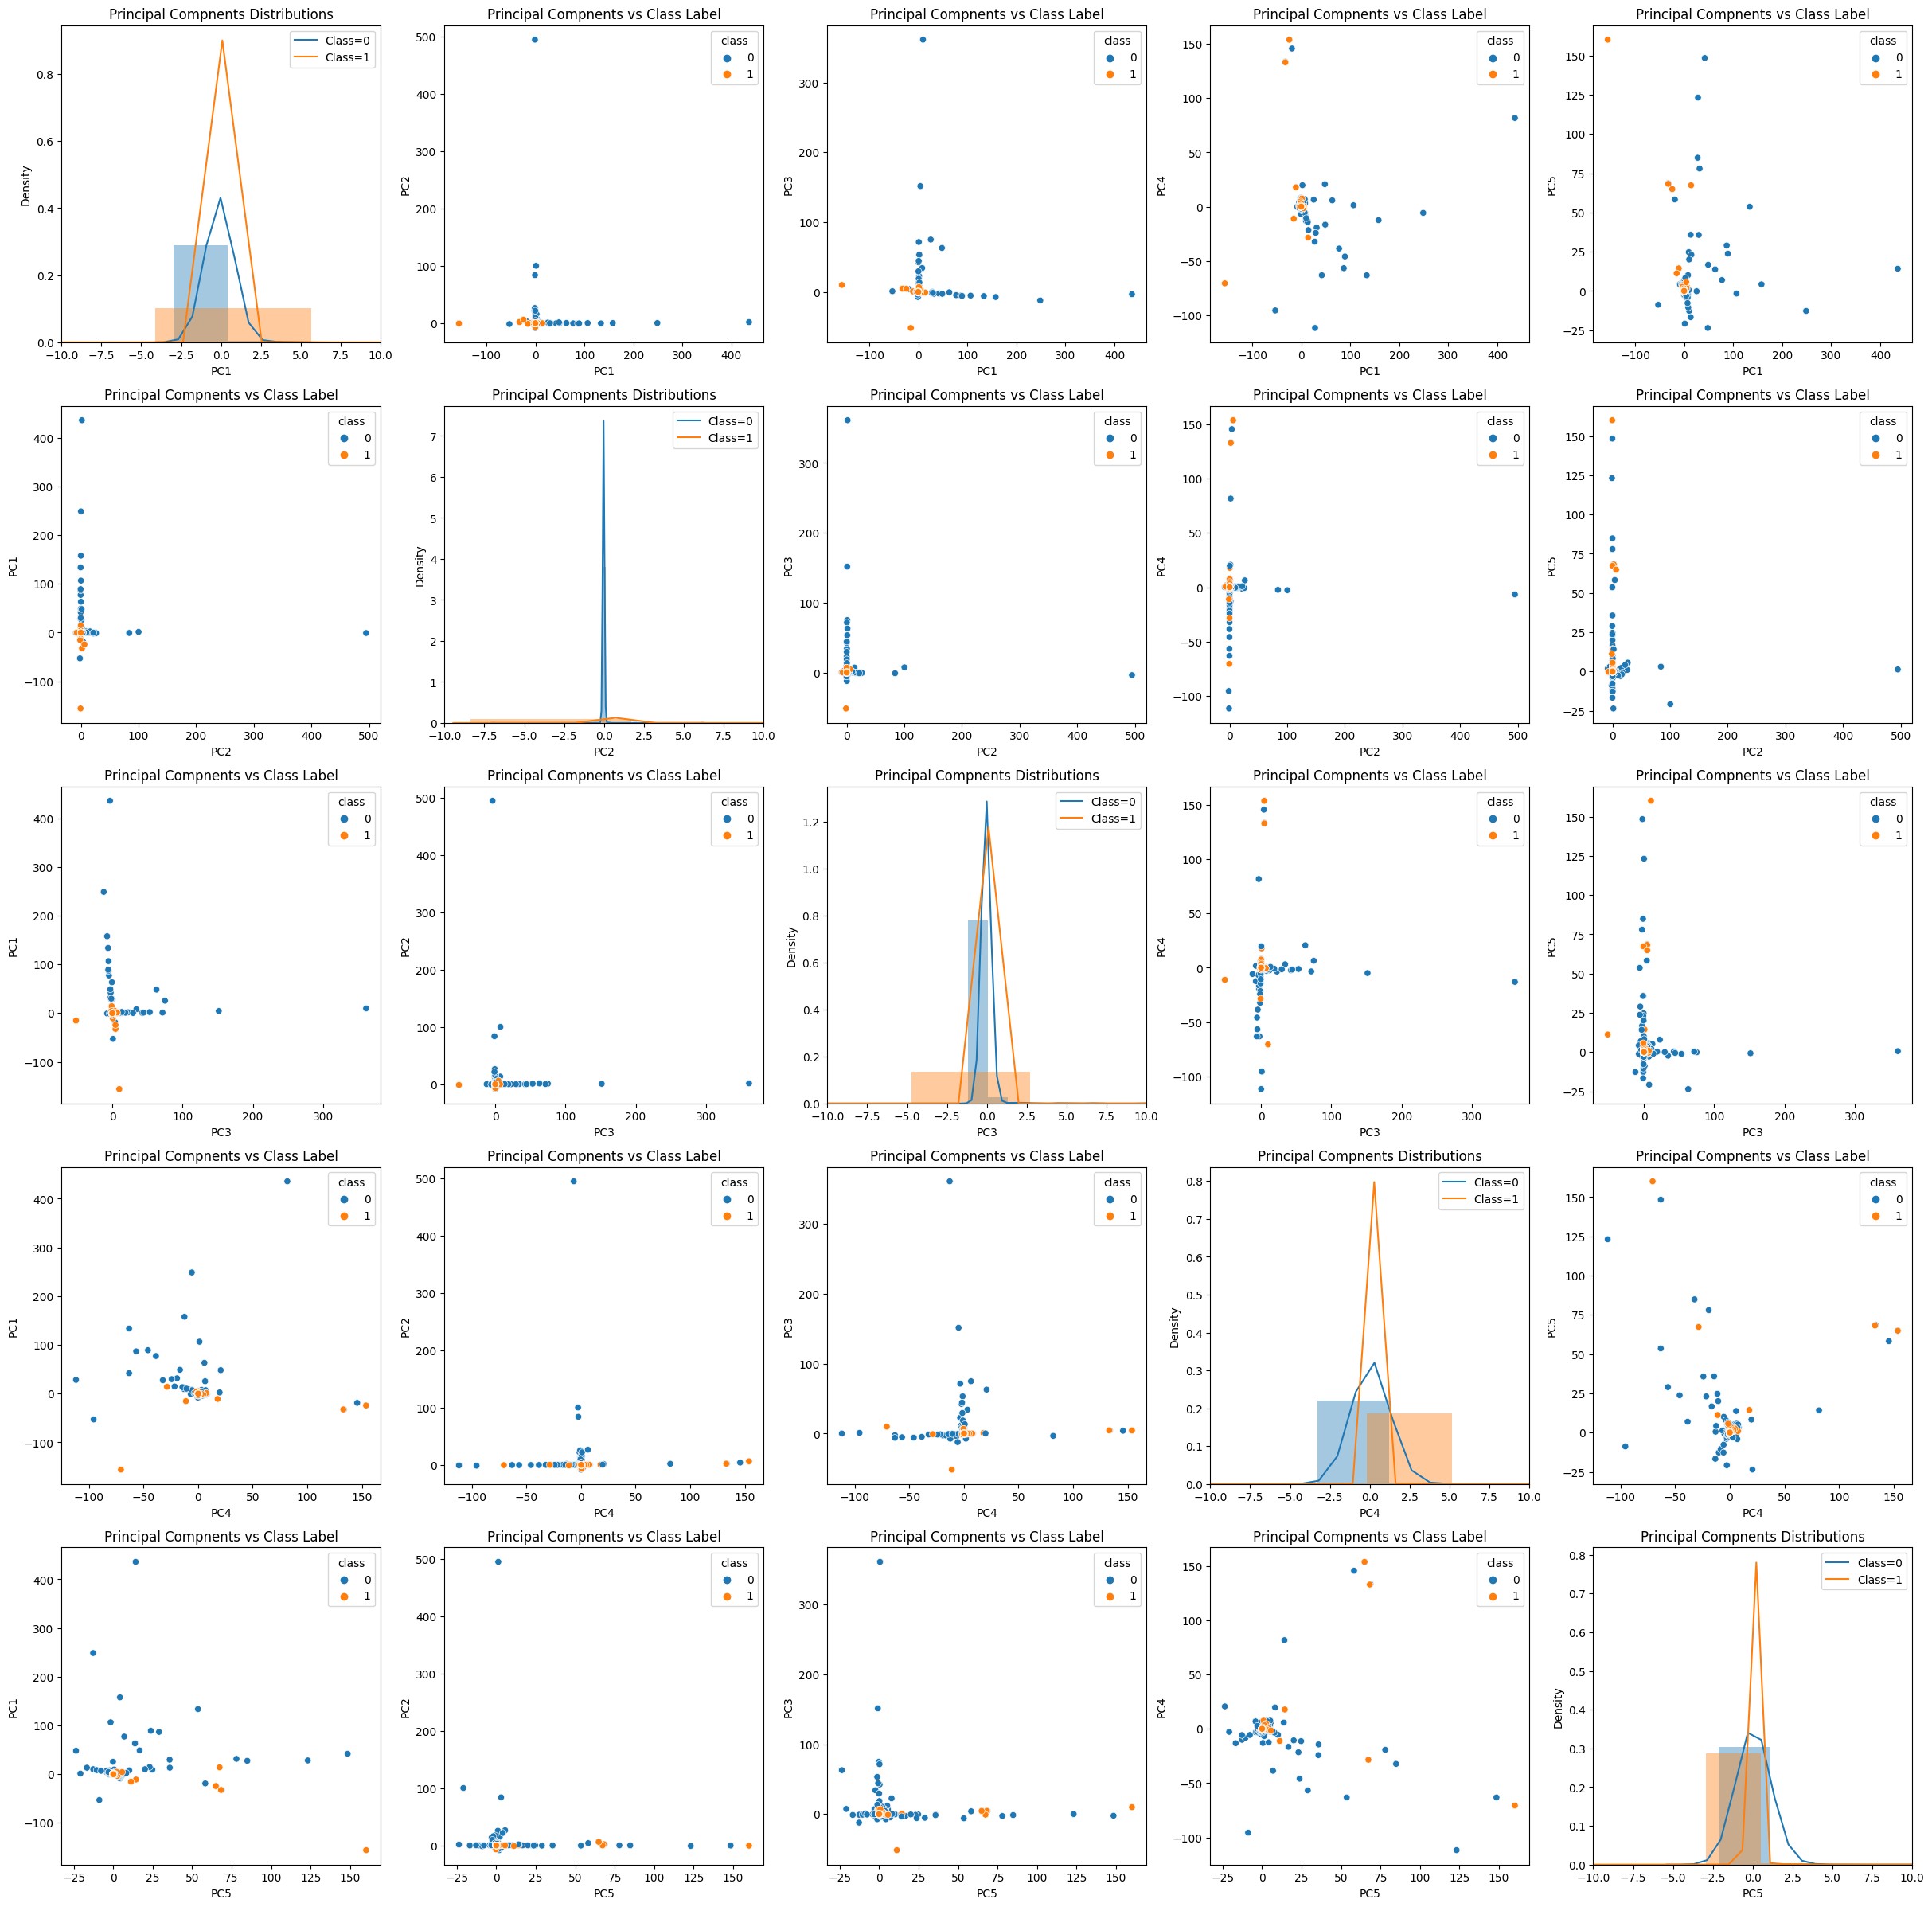

In [46]:
pca = PCA(n_components=.90)
components = pca.fit_transform(X_train_scaled)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(30,30))
pc_columns = []
for i in range(len(pca.components_)): 
    i +=1
    pc_columns.append(f'PC{i}')
    
pca_X_train = pd.DataFrame(data = components, columns = pc_columns, index=y_train.index)
pca_X_train_class_0 = pca_X_train[y_train == 1]
pca_X_train_class_1 = pca_X_train[y_train == 0]

for row in range(5): 
    for column in range(5): 
        ax = axes[row, column]
        if(row == column): 
            sns.distplot(pca_X_train_class_0[f'PC{row +1}'],ax=ax)
            sns.distplot(pca_X_train_class_1[f'PC{row +1}'],ax=ax)
            ax.set_xlim(-10,10);
            ax.set_title("Principal Compnents Distributions");
            ax.legend(['Class=0', 'Class=1'])
            continue;
        sns.scatterplot(data=pca_X_train, x=f'PC{row +1}', y=f'PC{column +1}', hue=y_train, ax=ax)
#         ax.set_xlim(-150000,150000);
#         ax.set_ylim(-150000,150000);
        ax.set_title("Principal Compnents vs Class Label");
        


For the PC3 and PC4 components that resulted from our principal component analysis, we can see that the loadings (after correcting for explained variance) are relatively spread out across many of our features/attributes. In Principal Component 4, we can see that attribute 2, attribute 25, and attribute 51, for example, contribute the most, but it is not super clear. This could be due to the fact that principal component anlysis is rotating the data in a way which makes all axis independent, but does not intentionally maximize seperation between class=0 and class=1. 

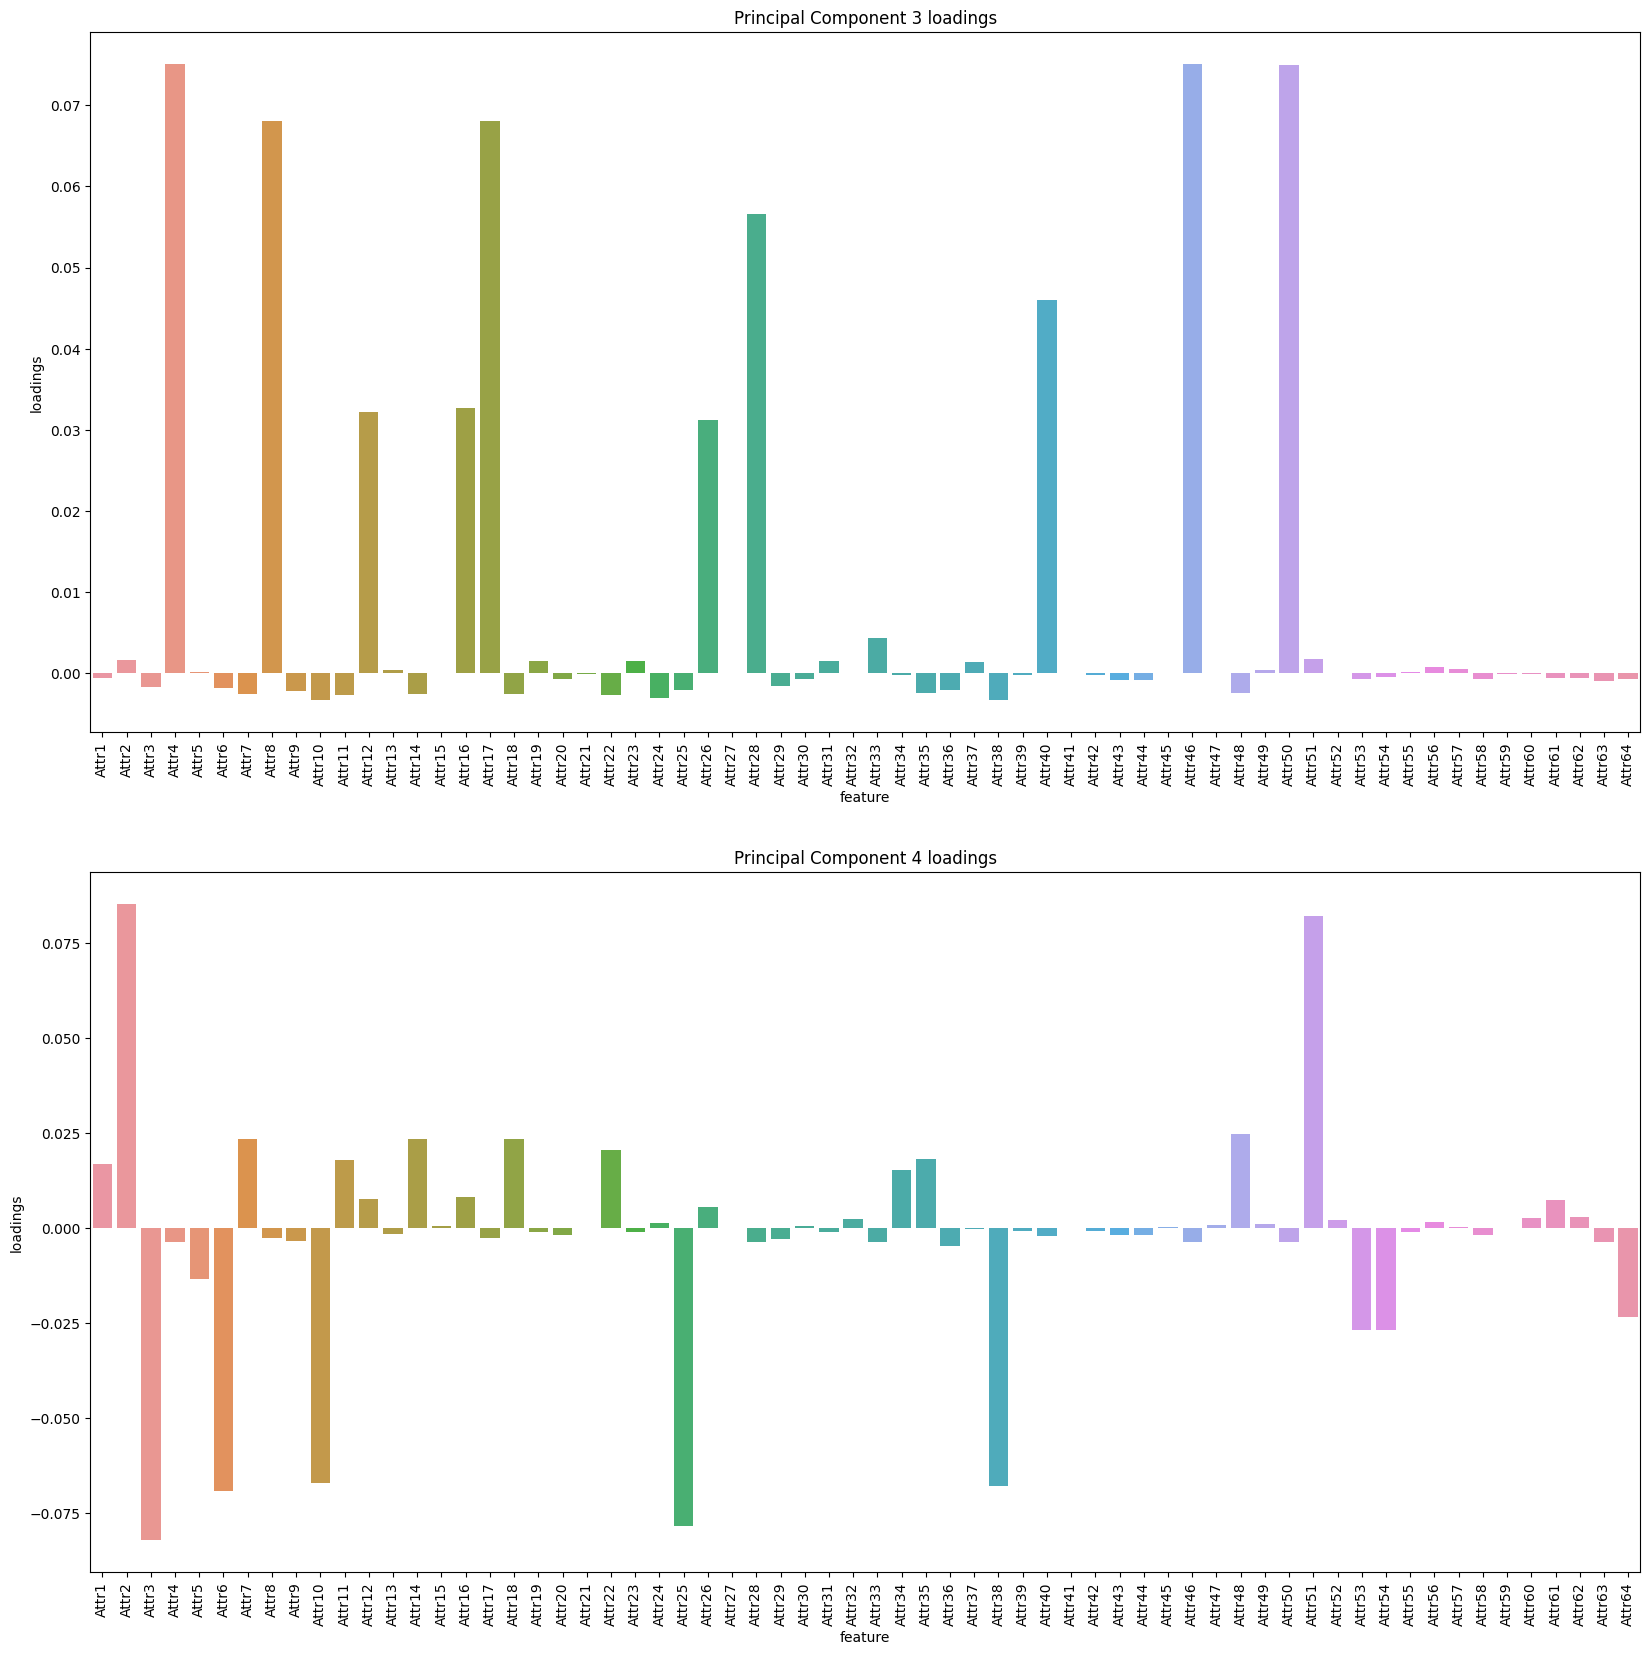

In [47]:
def plot_pca_loadings(pca_index, axes): 
    loadings_pca1 = pd.DataFrame(data=pca.components_[pca_index]/pca.explained_variance_[pca_index], columns=['loadings']);
    loadings_pca1['feature'] = X_train.columns;
    ax=axes[pca_index-2]
    sns.barplot(data=loadings_pca1, x='feature', y='loadings', ax=ax);
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_title(f"Principal Component {pca_index+1} loadings")


fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,20))
plot_pca_loadings(2, axes)
plot_pca_loadings(3, axes)


### Variable Selection
Although many of our variables are highly corrleated, removing the correlated variables from our model is misleading when considering variable importance and the inference afforded by the variable importance. That is, if 2 variables are highly corrleated, but both also predict class well, both variables should be considered highly important for our output classification, and a note should be made of the cross correlation that exists between those two important variables. We believe it would be misleading to remove multicolinear variables prior to feature importance. This is because: 
1. It will reduce the predictive power of the model to remove variables, 
2. It should not affect potential overfitting to necessarily leave correlated variables in a model, especially when they are deemed important via some gini impurity or entropy seperation scoring metric. 
3. Removing colinear variables might lead to misinformation or confusion that certain variables were not considered important, when in fact they are, they are just removed due to data redundancy. 

# Model Building & Evaluation

### Random Forest Classifier

First, Random Forest classifier is used for the binary classification of detecting bankrupt. Random Grid Search is used to apply parameter tuning and reduce the time of the execution. We specifically looked into `criterion` to use either Gini and Entropy, `n_estimators` to adjust number of trees, and lastly `max_depth` to determined depth of the trees. Then we will check the results of prediction using ROC Curve.

As can be seen in the results below, random forest classification is overfitting strongly. However, the test classification ROC AUC is still pretty good at AUC=0.93. In an attempt to reduce overfitting max tree depth was limited to 15 (out of the total 64 explanatory variables). Overfitting could likely be reduced further by limiting the minimum number of samples allowed in a leaf node. When we tried this, however, it unintentionally reduced test ROC AUC. Even though our Random Forest classifier is overfitting, we choose to accept that fact given the good test error. 

For the sampling method, we used the 5 fold cross validation on our train data set.

Our best Random Forest model has parameter with `n_estimators` with *100*, `min_samples_split` with *4*, `max_depth` with *15*, `criterion` with *entropy*, and `class_weight` with *balanced*

In [48]:
rf = RandomForestClassifier(random_state=0)
distributions = dict(criterion = ['gini', 'entropy'],
                    n_estimators = [100, 150],
                    max_depth = [10, 15],
                    class_weight = ['balanced'],
                    min_samples_split = [4, 6],
                    random_state=[0])

rf_clf = RandomizedSearchCV(rf, distributions, scoring='roc_auc',n_jobs=-1, cv=5)
rf_search = rf_clf.fit(X_train_scaled, y_train)

In [49]:
rf_search.best_params_

{'random_state': 0,
 'n_estimators': 100,
 'min_samples_split': 6,
 'max_depth': 15,
 'criterion': 'entropy',
 'class_weight': 'balanced'}

In [52]:
y_rf_pred = rf_search.best_estimator_.predict(X_train_scaled)


roc_auc_score(y_train, y_rf_pred, average=None)

0.9939613457166276

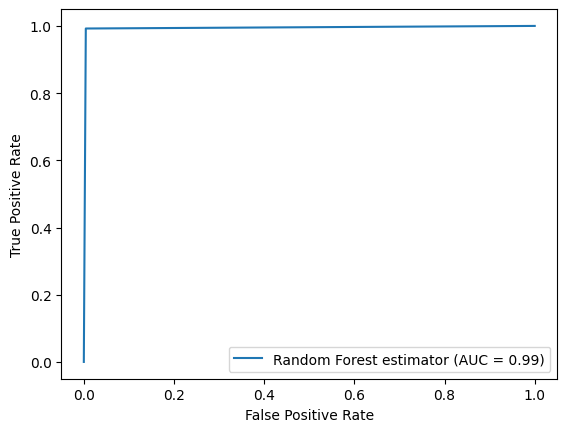

In [56]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_rf_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='Random Forest estimator')
display.plot()
plt.show()

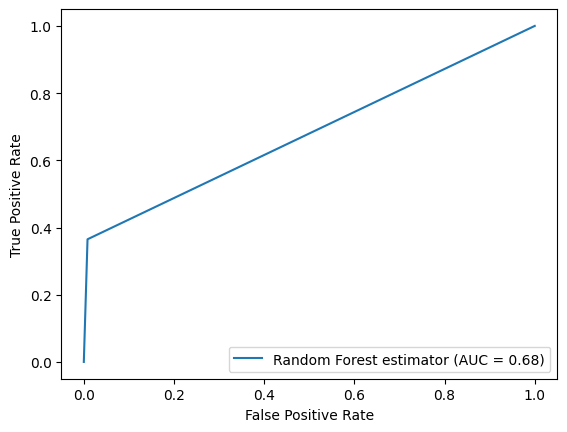

In [57]:
y_rf_pred = rf_search.best_estimator_.predict(X_test_scaled)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_rf_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='Random Forest estimator')
display.plot()
plt.show()

# metrics.RocCurveDisplay(rf_search.best_estimator_, X_test_scaled, y_test) 

In [101]:
roc_auc_score(y_test, y_rf_pred, average=None)

0.6783942156744356

### Random Forest Recall vs Precision
We got recall of `0.36` and precision of `0.72` which indicates it has less number of False Positive. The down side of the predicting the bankrupcy is not that bad that potential loans might be rejected. Whereas the down side of False Negative, predicting No bankruptcy as actual bankruptcy, has much higher consequences. Thus we want to have higher recall.

In [119]:
y_rf_pred = rf_search.best_estimator_.predict(X_test_scaled)

print(confusion_matrix(y_test, y_rf_pred, labels=[1,0]))
print('Recall:', recall_score(y_test, y_rf_pred))
print('Precision:', precision_score(y_test, y_rf_pred))

[[ 146  254]
 [  68 8213]]
Recall: 0.365
Precision: 0.6822429906542056


In [120]:
y_rf_pred_proba = rf_search.best_estimator_.predict_proba(X_test_scaled)
rf_result_df = pd.DataFrame(columns=['y_test', 'y_pred', 'y_proba_0', 'y_proba_1'])

rf_result_df['y_test'] = y_test
rf_result_df['y_pred'] = y_rf_pred
rf_result_df['y_proba_0'] = y_rf_pred_proba[:,0]
rf_result_df['y_proba_1'] = y_rf_pred_proba[:,1]

#### Tuning Threshold - Precision and Recall
From the Precision vs Recal plot, we are able to find that when the treshold is around `0.36` that recall and precision met. Since we want to have higher recall, we want to choose the threshold where it has higher recall than the precision.

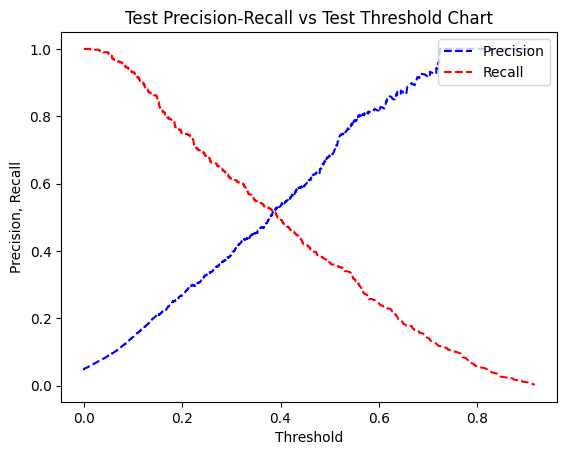

In [121]:
precision, recall, thresholds = precision_recall_curve(y_test, y_rf_pred_proba[:, 1]) 
plt.title("Test Precision-Recall vs Test Threshold Chart");
plt.plot(thresholds, precision[: -1], "b--", label="Precision");
plt.plot(thresholds, recall[: -1], "r--", label="Recall");
plt.ylabel("Precision, Recall");
plt.xlabel("Threshold");
plt.legend(loc="upper right");

In [122]:
optimal_thresholds = sorted(list(zip(np.abs(precision - recall), thresholds)), key=lambda i: i[0], reverse=False)[0][1]

In [123]:
print(f'Optimal Threshold is {optimal_thresholds}')

Optimal Threshold is 0.38606490008588407


##### Precision and Recall after tuning Threshold
After tuning the treshold with `0.386` we get the precision with `0.52` and recall with `0.52`.

In [124]:
predicted_proba = rf_search.best_estimator_.predict_proba(X_test_scaled)
predicted = (predicted_proba [:,1] >= optimal_thresholds).astype('int')

print(f'ROC AUC with threshold 0.386 is {roc_auc_score(y_test, predicted)}')
print(f'Recall with threshold 0.386 is {recall_score(y_test, predicted)}')
print(f'Precision with threshold 0.386 is {precision_score(y_test, predicted)}')

ROC AUC with threshold 0.386 is 0.748407197198406
Recall with threshold 0.386 is 0.52
Precision with threshold 0.386 is 0.52


### XGBoost

Besides being similar to Random forest in that outliers and skewed datasets are handled well (and we have a skewed dataset with many more class=0 instances than class=1 instances, XGBoost also handles missing values (although we already imputed them). 

Another benefit of the XGBoost model is that its explainability is visually much easier to follow than random forest's decision trees. 

The best XGBoost model was found with 5 fold cross validation and a parameter grid search. The number of estimators was found to be the best at 100, the gradient boosting subsample rate was best at 0.8 (the proportion of samples for each boosting iteration). This subsampling rate being somewhat high does induce some overfitting (as noted below). 

Below we can see that XGBoost performs relatively similarly to random forest, where it overfits the training data, but also performs much better than the above random forest model with an ROC AUC of .98. 

Finally, for the sampling method, we used the 5 fold cross validation on our train data set.

Our best Random Forest model has parameter with `n_estimators` with *100*, `subsample` with *0.8*, `max_depth` with *10*, `learning_rate` with *0.1*, and `reg_alpha` with *0.1*

In [66]:
xgb_param = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample':[0.6, 0.8],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1],
    'random_state':[0]
}
# xgb_cv = GridSearchCV(estimator = xgb.XGBClassifier(objective= 'binary:logistic'), 
xgboost = RandomizedSearchCV(estimator = xgb.XGBClassifier(objective= 'binary:logistic'), 
                            param_distributions = xgb_param, scoring='roc_auc',n_jobs=-1, cv=5)
xgb_search = xgboost.fit(X_train_scaled,y_train)

In [67]:
xgb_search.best_params_, xgb_search.best_score_

({'subsample': 0.8,
  'reg_alpha': 1e-05,
  'random_state': 0,
  'n_estimators': 150,
  'max_depth': 15,
  'learning_rate': 0.15},
 0.9668112888691185)

In [68]:
y_xgb_pred = xgb_search.best_estimator_.predict(X_train_scaled)

print(confusion_matrix(y_train, y_xgb_pred))

[[33033     0]
 [    0  1691]]


In [105]:
y_xgb_pred = xgb_search.best_estimator_.predict(X_train_scaled)

roc_auc_score(y_test, y_rf_pred, average=None)

0.6783942156744356

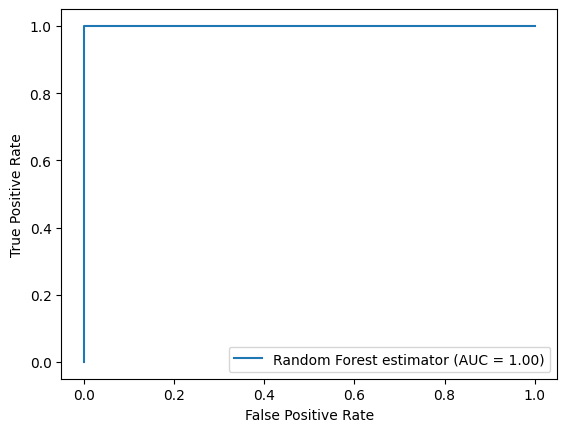

In [106]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_xgb_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='Random Forest estimator')
display.plot()
plt.show()

In [107]:
y_xgb_pred = xgb_search.best_estimator_.predict(X_test_scaled)

roc_auc_score(y_test, y_rf_pred, average=None)

0.6783942156744356

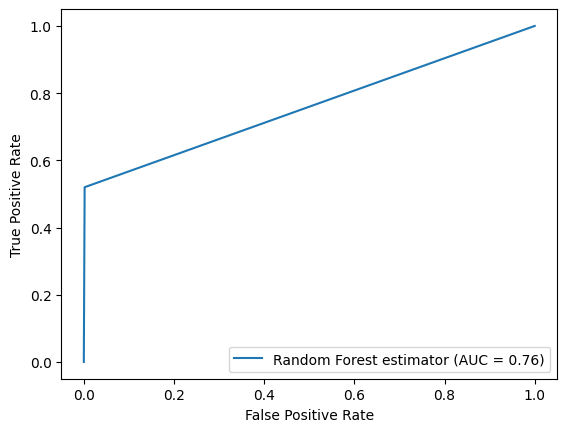

In [108]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_xgb_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='Random Forest estimator')
display.plot()
plt.show()

### XGB Tree Visualization

Below we have the visual representation of the tree that shows how the model decide the prediction for each leaves. We can see that the very first leaf uses `Attr29` for the decision making. We can see that the Attr29 might be important feature to be considered. The user with domain knowledge may have better understanding and see the impacts of the decision made for each leaves.

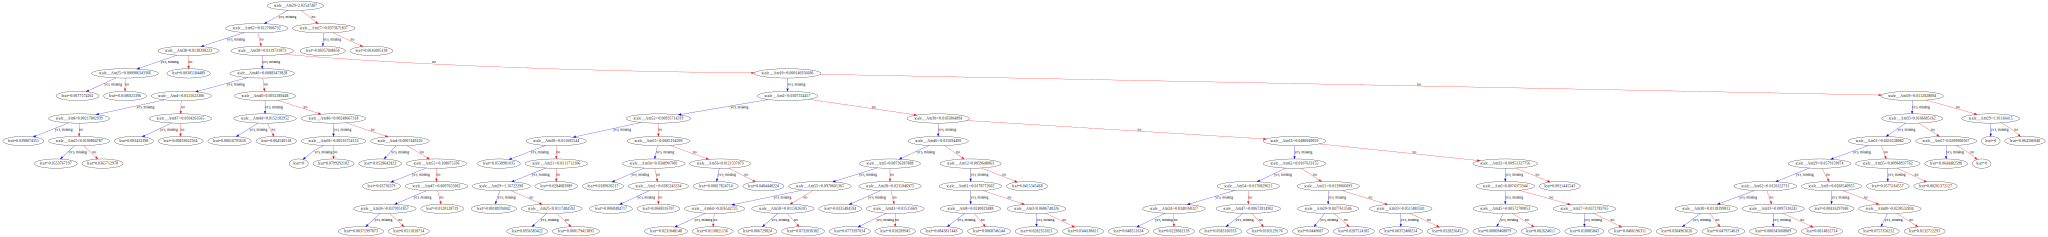

In [ ]:
xgb.to_graphviz(xgb_search.best_estimator_, num_trees=xgb_search.best_estimator_.best_iteration)

### XGBoost Recall vs Precision
We got recall of `0.54` and precision of `0.96` which indicates it has less number of False Positive. As we mentioned above on Random Forest Recall vs Precision, the down side of False Negative, predicting No bankruptcy as actual bankruptcy, has much higher consequences. Thus we want to have higher recall.

In [109]:
y_xgb_pred = xgb_search.best_estimator_.predict(X_test_scaled)

print(confusion_matrix(y_test, y_xgb_pred))
print('Recall:', recall_score(y_test, y_xgb_pred))
print('Precision:', precision_score(y_test, y_xgb_pred))

[[8266   15]
 [ 192  208]]
Recall: 0.52
Precision: 0.9327354260089686


In [110]:
y_xgb_pred_proba = xgb_search.best_estimator_.predict_proba(X_test_scaled)
xgb_result_df = pd.DataFrame(columns=['y_test', 'y_pred', 'y_proba_0', 'y_proba_1'])

xgb_result_df['y_test'] = y_test
xgb_result_df['y_pred'] = y_xgb_pred_proba
xgb_result_df['y_proba_0'] = y_xgb_pred_proba[:,0]
xgb_result_df['y_proba_1'] = y_xgb_pred_proba[:,1]

#### Tuning Threshold - Precision and Recall
From the Precision vs Recal plot, we are able to find that when the treshold is around `0.12` where recall and precision met. Since we want to balance the precision and recal, we may choose threshold point where it met the intersection point.

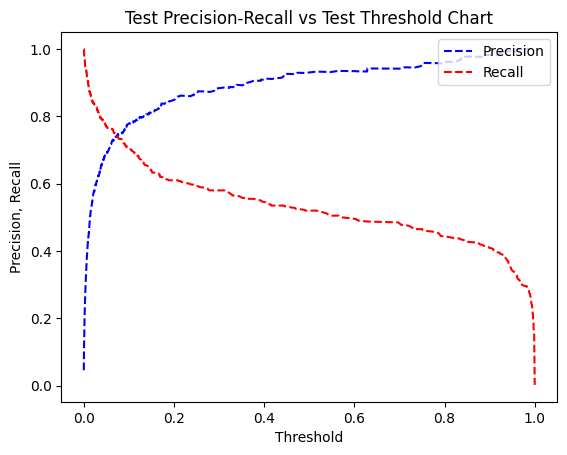

In [113]:
precision, recall, thresholds = precision_recall_curve(y_test, y_xgb_pred_proba[:, 1]) 
plt.title("Test Precision-Recall vs Test Threshold Chart");
plt.plot(thresholds, precision[: -1], "b--", label="Precision");
plt.plot(thresholds, recall[: -1], "r--", label="Recall");
plt.ylabel("Precision, Recall");
plt.xlabel("Threshold");
plt.legend(loc="upper right");

In [114]:
optimal_thresholds = sorted(list(zip(np.abs(precision - recall), thresholds)), key=lambda i: i[0], reverse=False)[0][1]

In [115]:
print(f'Optimal Threshold is {optimal_thresholds}')

Optimal Threshold is 0.07332910597324371


##### Precision and Recall after tuning Threshold
After tuning the treshold with `0.073` we get the precision with `0.11` and recall with `0.96`

In [117]:
predicted_proba = rf_search.best_estimator_.predict_proba(X_test_scaled)
predicted = (predicted_proba [:,1] >= optimal_thresholds).astype('int')

print(f'ROC AUC with threshold 0.073 is {roc_auc_score(y_test, predicted)}')
print(f'Recall with threshold 0.073 is {recall_score(y_test, predicted)}')
print(f'Precision with threshold 0.073 is {precision_score(y_test, predicted)}')

ROC AUC with threshold 0.073 is 0.7957831179809202
Recall with threshold 0.073 is 0.96
Precision with threshold 0.073 is 0.11179039301310044


# Model Interpretability & Explainability

### Random Forest Variable Importance
As can be seen below, Attribute 27  34 and 24 have the highest random forest variable importance. Without domain knowledge it is hard to know exactly why this is the case. Being that over 100 short decision trees were run and, when considering the imalanced dataset that we have, using entropy for splitting, these attributes emerged as the most important. These varaibles were considered important for a model which is overfit to the training data, so it is possible that given a model which generalizes better or given more data, we could have a change in the order or variable importance. However, it is unlikely that Attribute 27's variable importance would change much as it's importance is over twice the imoprtance of the next most important attribute (attribute 34). 

In [ ]:
top_features_to_select = 20
dset = pd.DataFrame()
dset['attr'] = X_train_scaled.columns
dset['importance'] = rf_search.best_estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=True)[len(dset)-top_features_to_select:]
col_by_importance = dset.attr.tolist()

plt.figure(figsize=(15, 25));
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2');
plt.title('Random Forest Classifier - Feature Importances', fontsize=20, fontweight='bold', pad=20);
plt.xlabel('Importance', fontsize=14, labelpad=20);

### XGBoost Variable Importance
As can be seen below, Attribute 24  21 and 29, and 25 have the highest random forest variable importance. Again, without domain knowledge it is hard to know exactly why this is the case. What is interesting is that the order of this variable importance is different than than random forest. Again, this is an overfit model so the exact order of these variables are likely to change, but the top 10 vs the bottom 10 are unlikely to change significantly. 


In [ ]:
fig, ax = plt.subplots(figsize=(15, 25))
xgb.plot_importance(xgb_model, ax=ax)

### Overall importance
Noting that XGBoost and Random Forest slightly disagree, it is important to look for the intersection of the top features for both models when considering variable importance inference. Attributes which exist in the top 10 most important features for both models include: 
- Attribute 24
- Attribute 27
- Attribute 6
- possibly attribute 40
    
These attributes are likely important because two seperate models, that rely on fairly different underlying algorithms, both recommended these as important. 

# Case Conclusions

After imputing missing data via a "highest correlated covariant" model, and given the financial dataset (with over 40,000 samples), is skewed with the `class` attribute being under represented at a value of 1, Random Forest and XGBoost are desirable models to predict the `class` attribute. Although both models, when trained on 80% of the overall data, overfit, they both perform relatively well considering test data. For this data, we prefer recall over precision becausee the downside of missing a bankrupcy prediction can be high for potential lenders. While **XGBoost** outperforms Random Forest, with a precision of `0.11` and a recall of `0.96` when a cutoff threshold of `0.077` is chosen, both models agree that the following attributes are important when predicting `class`:    
- Attribute 24
- Attribute 27
- Attribute 6
- possibly attribute 40.
 
Ultimately,  domain knowledge would be required to make more informed decisions on variable importance, our imputation strategy, and on sampling strategies. 